In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import matplotlib.pyplot as plt
from hydra import initialize, compose
from pathlib import Path
from collections import defaultdict
import matplotlib.colors
import numpy as np

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths", ):
    filepaths = compose(config_name="filepaths")

In [4]:
Rs = [0, 1, 2, 3, 4]
dts = [91, 13, '04', '02', '01']
others = ['mechinformed', 'rdchiral', 'imt']
mechinferred_template_sizes = defaultdict(list)
rcr_template_sizes = defaultdict(list)
bad_rules = {'rcr': set(), 'mechinferred': set()}
mechinferred_rules = []
rcr_rules = []
other_rules = []
other_template_sizes = defaultdict(list)

for dt in dts:
    df = pd.read_csv(
        Path(filepaths.processed_data) / f"mechinferred_dt_{dt}_rules.csv",
    )
    mechinferred_rules.append(df)
    for _, row in df.iterrows():
        sma = row["smarts"]
        rxn = AllChem.ReactionFromSmarts(sma)
        mechinferred_template_sizes[dt].append(
            sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
        )

for R in Rs:
    if R == 0:
        df = pd.read_csv(
            Path(filepaths.rules) / "rc_plus_0_rules.csv",
        )
    else:
        df = pd.read_csv(
            Path(filepaths.processed_data) / f"rc_plus_{R}_rules.csv",
        )
    rcr_rules.append(df)
    for _, row in df.iterrows():
        sma = row["smarts"]
        rxn = AllChem.ReactionFromSmarts(sma)
        rcr_template_sizes[R].append(
            sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
        )

for other in others:
    if other == 'imt':
        df = pd.read_csv(
            Path(filepaths.rules) / "imt_rules.csv",
        )
    else:
        df = pd.read_csv(
            Path(filepaths.processed_data) / f"{other}_rules.csv",
        )
    other_rules.append(df)
    for _, row in df.iterrows():
            sma = row["smarts"]
            rxn = AllChem.ReactionFromSmarts(sma)
            other_template_sizes[other].append(
                sum(rct.GetNumAtoms() for rct in rxn.GetReactants())
            )

In [8]:
colors = {
    'rc_plus_0_rules': matplotlib.colors.to_rgba("black", alpha=0.3),
    'rc_plus_1_rules':matplotlib.colors.to_rgba("black", alpha=0.45),
    'rc_plus_2_rules': matplotlib.colors.to_rgba("black", alpha=0.6),
    'rc_plus_3_rules': matplotlib.colors.to_rgba("black", alpha=0.85),
    'rc_plus_4_rules': matplotlib.colors.to_rgba("black", alpha=1.0),
    'mechinferred_dt_91_rules': matplotlib.colors.to_rgba("purple", alpha=0.3),
    'mechinferred_dt_13_rules': matplotlib.colors.to_rgba("purple", alpha=0.45),
    'mechinferred_dt_04_rules': matplotlib.colors.to_rgba("purple", alpha=0.6),
    'mechinferred_dt_02_rules': matplotlib.colors.to_rgba("purple", alpha=0.85),
    'mechinferred_dt_01_rules': matplotlib.colors.to_rgba("purple", alpha=1.0),
    'mechinformed_rules': matplotlib.colors.to_rgba("green"),
    'rdchiral_rules': matplotlib.colors.to_rgba("blue"),
    'imt_rules': matplotlib.colors.to_rgba("darkorange"),
}

other_names = {
    'mechinformed_rules': "Mechinformed",
    'rdchiral_rules': "RDChiral",
    'imt_rules': "Pathway-level clustering",
}

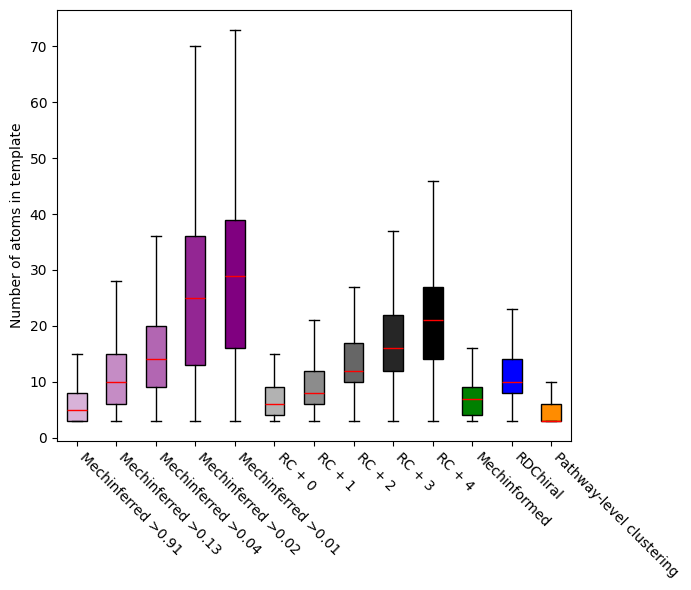

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))
data = []
width = 0.5

for dt, cts in mechinferred_template_sizes.items():
    data.append(cts)
for R, cts in rcr_template_sizes.items():
    data.append(cts)
for other, cts in other_template_sizes.items():
    data.append(cts)

positions = list(range(len(mechinferred_template_sizes) + len(rcr_template_sizes) + len(other_template_sizes)))

bw_plot = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, showfliers=False, medianprops={'color': 'red'})

for path, dt in zip(bw_plot['boxes'], mechinferred_template_sizes.keys()):
    color_key = f"mechinferred_dt_{dt}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

for path, R in zip(bw_plot['boxes'][len(mechinferred_template_sizes):], rcr_template_sizes.keys()):
    color_key = f"rc_plus_{R}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

for path, other in zip(bw_plot['boxes'][len(mechinferred_template_sizes) + len(rcr_template_sizes):], other_template_sizes.keys()):
    color_key = f"{other}_rules"
    color = colors[color_key]
    path.set_facecolor(color)

ax.set_xticks(positions)
xticklabels = [f"Mechinferred >{int(dt)/100:.2f}" for dt in dts] + [f"RC + {R}" for R in Rs] + [other_names[f"{other}_rules"] for other in others]
ax.set_xticklabels(xticklabels, rotation=-45, ha='left')
ax.set_ylabel("Number of atoms in template")
plt.tight_layout()
fig.savefig(Path(filepaths.figures) / "template_size_boxplot.svg", format='svg')
plt.show()

In [16]:
data = []
width = 0.5

def get_row(cts):
    cts = np.array(cts)
    return {
        'min': np.min(cts),
        '25%': np.percentile(cts, 25),
        'median': np.median(cts),
        'mean': np.mean(cts),
        '75%': np.percentile(cts, 75),
        'max': np.max(cts),
    }

for dt, cts in mechinferred_template_sizes.items():
    data.append(
        {'name': f"mechinferred_dt_{dt}_rules", **get_row(cts)}
    )
for R, cts in rcr_template_sizes.items():
    data.append(
        {'name': f"rc_plus_{R}_rules", **get_row(cts)}
    )
for other, cts in other_template_sizes.items():
    data.append(
        {'name': f"{other}_rules", **get_row(cts)}
    )

template_stats = pd.DataFrame(data)
template_stats.to_csv(Path(filepaths.processed_data) / "template_size_stats.csv", index=False)
template_stats.head(20)

,name,min,25%,median,mean,75%,max
0,mechinferred_dt_91_rules,3,3.0,5.0,5.832289,8.0,17
1,mechinferred_dt_13_rules,3,6.0,10.0,10.805556,15.0,40
2,mechinferred_dt_04_rules,3,9.0,14.0,16.901662,20.0,137
3,mechinferred_dt_02_rules,3,13.0,25.0,27.505676,36.0,178
4,mechinferred_dt_01_rules,3,16.0,29.0,30.725779,39.0,187
5,rc_plus_0_rules,3,4.0,6.0,6.695736,9.0,15
6,rc_plus_1_rules,3,6.0,8.0,8.889249,12.0,31
7,rc_plus_2_rules,3,10.0,12.0,13.415592,17.0,35
8,rc_plus_3_rules,3,12.0,16.0,17.150463,22.0,44
9,rc_plus_4_rules,3,14.0,21.0,20.757402,27.0,51
